In [1]:
### Display
from IPython.display import display
## Data Handling
import pandas as pd
import pm4py
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random
import numpy as np
from cvxopt.misc_solvers import scale
from pm4py.objects.petri_net import semantics
from pm4py.objects.process_tree.obj import Operator


In [2]:
# please do not change or delete this cell (probably not needed, but just in case ;))
random.seed(42)
np.random.seed(42)

In [3]:
log = pm4py.read_xes('fines_event_log.xes', variant="rustxes")
log

,expense,concept:name,case:concept:name,penalty,time:timestamp,case:fine,paymentAmount,dismissal
0,NaN,Create Fine,A1,NaN,2006-07-23 22:00:00+00:00,3500,NaN,None
1,1100.0,Send Fine,A1,NaN,2006-12-04 23:00:00+00:00,3500,NaN,None
2,NaN,Create Fine,A10008,NaN,2007-03-19 23:00:00+00:00,3600,NaN,None
3,1300.0,Send Fine,A10008,NaN,2007-07-16 22:00:00+00:00,3600,NaN,None
4,NaN,Insert Fine Notification,A10008,NaN,2007-08-01 22:00:00+00:00,3600,NaN,None
...,...,...,...,...,...,...,...,...
267247,NaN,Create Fine,V9999,NaN,2002-09-06 22:00:00+00:00,13100,NaN,None
267248,1516.0,Send Fine,V9999,NaN,2002-10-24 22:00:00+00:00,13100,NaN,None
267249,NaN,Insert Fine Notification,V9999,NaN,2002-11-03 23:00:00+00:00,13100,NaN,None
267250,NaN,Add penalty,V9999,13100.0,2003-01-02 23:00:00+00:00,13100,NaN,None


In [4]:
# number of cases
number_cases = log["case:concept:name"].nunique()
number_cases

71522

In [5]:
number_activities = log["concept:name"].nunique()
number_activities

11

# a) Full Model Discovery

In [6]:
# (1) 标准 Inductive Miner（不加噪声阈值），挖 Petri net
net, im, fm = pm4py.discover_petri_net_inductive(log)  # 按题目要求默认参数

# (2) 从“模型”推导可能的开始活动：
#     从初始标识 im 出发，只走 τ(=label is None) 扩展可达标识；
#     在这些标识上，凡是可见迁移(label != None)且可启用，其 label 就是可能的 start activity
def get_start_activities_from_model(net, im):
    def marking_key(m):
        # 用 place.name 做稳定 hash（避免 Place 对象不可序列化）
        return tuple(sorted((p.name, c) for p, c in m.items()))

    start_acts = set()
    queue = [im]
    visited = {marking_key(im)}

    while queue:
        m = queue.pop(0)
        for t in semantics.enabled_transitions(net, m):
            if t.label is None:
                # τ 迁移：继续扩展
                m2 = semantics.execute(t, net, m)
                k = marking_key(m2)
                if k not in visited:
                    visited.add(k)
                    queue.append(m2)
            else:
                # 可见迁移：它的 label 就是可能的开始活动
                start_acts.add(t.label)

    return start_acts

start_activities = get_start_activities_from_model(net, im)
#第一个小问
sorted(start_activities)

#   第二个小问
# 1) 用 Inductive Miner 发现 process tree（标准参数）
tree = pm4py.discover_process_tree_inductive(log)
appeal_label = "Appeal to Judge"
def leaves(subtree):
    """返回 subtree 下所有可见活动(label != None)"""
    if subtree.label is not None:
        return {subtree.label}
    if not subtree.children:
        return set()
    s = set()
    for ch in subtree.children:
        s |= leaves(ch)
    return s

def flatten_blocks(subtree):
    """
    把一个子树展开成“有序块”：
    - SEQUENCE: 按顺序拼接子块
    - PARALLEL: 一个无序块（里面活动可任意顺序/交错）
    - XOR: 这里不做选择（在本题里我们只在‘已选择含 Appeal 的分支’上调用它）
    - 叶子: 单活动块
    """
    if subtree.label is not None:
        return [ {subtree.label} ]
    if subtree.operator == Operator.SEQUENCE:
        out = []
        for ch in subtree.children:
            out += flatten_blocks(ch)
        return out
    if subtree.operator == Operator.PARALLEL:
        return [ leaves(subtree) ]   # 一个无序块
    # 其他情况先保守处理：当成一个块
    return [ leaves(subtree) ]

def find_nodes_by_label(node, label):
    res = []
    if node.label == label:
        res.append(node)
    for ch in node.children or []:
        res += find_nodes_by_label(ch, label)
    return res

targets = find_nodes_by_label(tree, appeal_label)
len(targets), targets[0].label if targets else None
start_activities
def mandatory_around_activity(leaf_node):
    must_before_blocks = []
    must_after_blocks  = []
    must_concurrent = set()

    cur = leaf_node
    while cur.parent is not None:
        p = cur.parent

        if p.operator == Operator.SEQUENCE:
            idx = p.children.index(cur)

            # 在 SEQUENCE 里：当前节点前面的兄弟，必在前；后面的兄弟，必在后
            for sib in p.children[:idx]:
                must_before_blocks = flatten_blocks(sib) + must_before_blocks
            for sib in p.children[idx+1:]:
                must_after_blocks  = must_after_blocks + flatten_blocks(sib)

        elif p.operator == Operator.PARALLEL:
            # AND 并行：其他分支也必须发生，但相对 cur 的先后不固定
            for sib in p.children:
                if sib is not cur:
                    must_concurrent |= leaves(sib)

        # XOR：选了含 Appeal 的分支即可，其他分支不强制
        # LOOP：这里先不做复杂推导（一般罚单流程里 appeal 通常不在 loop 结构的“必经”里）

        cur = p

    mandatory_activities = set().union(*must_before_blocks) | {leaf_node.label} | set().union(*must_after_blocks) | must_concurrent
    return must_before_blocks, must_after_blocks, must_concurrent, mandatory_activities

leaf = targets[0]
must_before_blocks, must_after_blocks, must_concurrent, mandatory_activities = mandatory_around_activity(leaf)
#第二小问答案
must_before_blocks, must_after_blocks, sorted(must_concurrent), sorted(mandatory_activities)


#第三小问

# 1) 找出所有“可能重复”的活动：在 LOOP 子树里出现过的活动
def activities_in_loops(node):
    repeatable = set()

    def dfs(n, in_loop=False):
        nonlocal repeatable
        if n is None:
            return

        # 如果当前节点是 LOOP，那么它的所有可见活动都可能重复
        if n.operator == Operator.LOOP:
            repeatable |= leaves(n)
            # 继续深入（loop 内部可能还有 nested loop）
            for ch in n.children or []:
                dfs(ch, in_loop=True)
            return

        for ch in n.children or []:
            dfs(ch, in_loop)

    dfs(node)
    return repeatable

repeatable_acts = activities_in_loops(tree)
sorted(repeatable_acts)

#第四小问
TARGET = "Send for Credit Collection"
FORBID = "Send Fine"

def marking_key(m):
    return tuple(sorted((p.name, c) for p, c in m.items()))

# 2) 在模型里做 BFS：找“包含 TARGET 且不包含 FORBID”的一条可执行序列（witness）
def exists_credit_without_sendfine(net, im, max_steps=200):
    # state: (marking, seen_forbid, trace_labels_tuple)
    start = (im, False, tuple())
    q = [start]
    visited = {(marking_key(im), False)}  # 不把 trace 放进 visited，避免爆炸

    while q:
        m, seen_forbid, tr = q.pop(0)

        # 防止无限探索（模型里可能有循环，比如 Payment）
        if len(tr) > max_steps:
            continue

        for t in semantics.enabled_transitions(net, m):
            m2 = semantics.execute(t, net, m)

            if t.label is None:
                # τ 迁移：不改变 trace
                seen2 = seen_forbid
                tr2 = tr
            else:
                # 可见活动：追加到 trace
                seen2 = seen_forbid or (t.label == FORBID)
                tr2 = tr + (t.label,)

                # 一旦执行到了 TARGET，检查是否从未出现 FORBID
                if t.label == TARGET and (not seen2):
                    return True, tr2

            key = (marking_key(m2), seen2)
            if key not in visited:
                visited.add(key)
                q.append((m2, seen2, tr2))

    return False, None

possible, witness = exists_credit_without_sendfine(net, im)

possible, witness[:30] if witness else None

(True,
 ('Create Fine',
  'Notify Result Appeal to Offender',
  'Send for Credit Collection'))

# b) Behavior Case Frequency

For this question, we recommend using the following event log filtering methods of PM4PY:
- filter_eventually_follows_relation (https://processintelligence.solutions/static/api/2.7.17/generated/pm4py.filtering.filter_eventually_follows_relation.html)
- filter_directly_follows_relation (https://processintelligence.solutions/static/api/2.7.17/generated/pm4py.filtering.filter_directly_follows_relation.html)

In [7]:
import pandas as pd
import pm4py
df = pm4py.convert_to_dataframe(log)[["case:concept:name", "concept:name", "time:timestamp"]].copy()
df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])

case_col = "case:concept:name"
act_col  = "concept:name"
time_col = "time:timestamp"

# 每个 case、每个活动的最早发生时间（用于先后关系判断）
first_time = df.pivot_table(index=case_col, columns=act_col, values=time_col, aggfunc="min")

t_payment   = first_time["Payment"]
t_credit    = first_time["Send for Credit Collection"]
t_penalty   = first_time["Add penalty"]
t_sendfine  = first_time["Send Fine"]
t_judge     = first_time["Appeal to Judge"]
t_pref_send = first_time["Send Appeal to Prefecture"]
t_notify    = first_time["Notify Result Appeal to Offender"]

# (1) A payment is made but the case is still sent for credit collection.
count1 = int((t_payment.notna() & t_credit.notna()).sum())

# (2) A penalty is added before the fine is sent to the offender via post.
count2 = int((t_penalty.notna() & t_sendfine.notna() & (t_penalty < t_sendfine)).sum())

# (3) An appeal to the prefecture or a judge is made after a payment.
payment_min = df[df[act_col] == "Payment"].groupby(case_col)[time_col].min()
appeal_max  = df[df[act_col].isin(["Appeal to Judge", "Send Appeal to Prefecture"])].groupby(case_col)[time_col].max()

# 对齐索引（让两个 Series 有相同的 case 集合）
appeal_max = appeal_max.reindex(payment_min.index)

count3 = int((appeal_max > payment_min).fillna(False).sum())


# (4) The offender is notified about the result of an appeal without any appeal having been made.
count4 = int((t_notify.notna() & t_judge.isna() & t_pref_send.isna()).sum())

count1, count2, count3, count4

(1013, 0, 10, 17)

# c) Variants

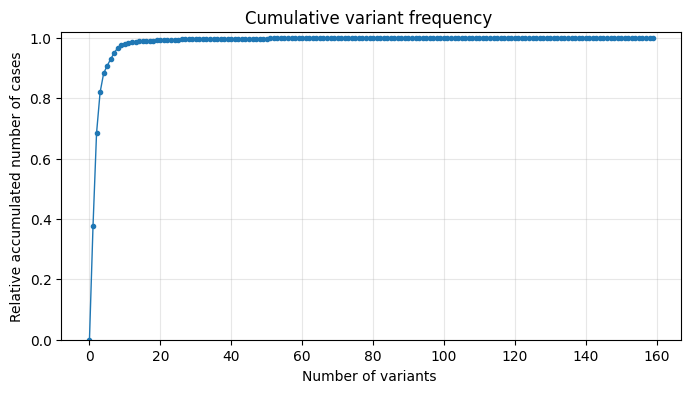

,rank,cases,variant,share
0,1,26872,Create Fine -> Send Fine -> Insert Fine Notifi...,0.375717
1,2,22078,Create Fine -> Payment,0.308688
2,3,9631,Create Fine -> Send Fine,0.134658
3,4,4507,Create Fine -> Send Fine -> Insert Fine Notifi...,0.063016
4,5,1806,Create Fine -> Send Fine -> Insert Fine Notifi...,0.025251


In [8]:

from pm4py.statistics.variants.log import get as variants_get

# 1) 统计每个 variant 覆盖的 case 数（variant -> traces 列表）
variants = variants_get.get_variants(log)  # dict: {variant_tuple: [trace1, trace2, ...]}
variant_counts = {v: len(traces) for v, traces in variants.items()}

# 2) 按频数降序排序（题目 hint：先降序，再累计）
sorted_items = sorted(variant_counts.items(), key=lambda x: x[1], reverse=True)
sorted_counts = np.array([cnt for _, cnt in sorted_items], dtype=float)

# 3) 累计覆盖率（y 轴：累计覆盖的 case 比例）
total_cases = log["case:concept:name"].nunique()
cum_ratio = np.cumsum(sorted_counts) / total_cases  # 0~1

# 4) 画累计曲线：在最前面加一个“0th variant = 0 cases”，确保从 (0,0) 开始
x = np.arange(0, len(sorted_counts) + 1)                 # 0..#variants
y = np.concatenate([[0.0], cum_ratio])                   # prepend 0

plt.figure(figsize=(8, 4))
plt.plot(x, y, marker="o", markersize=3, linewidth=1)
plt.xlabel("Number of variants ")
plt.ylabel("Relative accumulated number of cases")
plt.title("Cumulative variant frequency ")
plt.ylim(0, 1.02)
plt.grid(True, alpha=0.3)
plt.show()

# 5) 输出 top-5 variants + 覆盖 case 数
top5 = sorted_items[:5]
top5_df = pd.DataFrame({
    "rank": range(1, 6),
    "cases": [cnt for v, cnt in top5],
    "variant": [" -> ".join(v) for v, cnt in top5],
    "share": [cnt / total_cases for v, cnt in top5],
})
top5_df

# d) Case overview

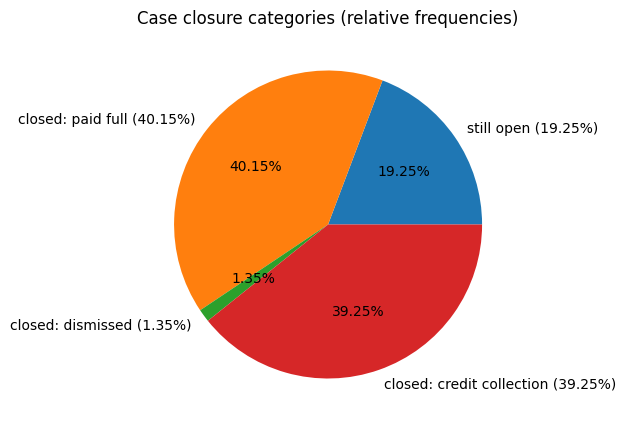

(still_open                  13766
 closed_paid_full            28718
 closed_dismissed              966
 closed_credit_collection    28072
 Name: count, dtype: int64,
 still_open                  0.1925
 closed_paid_full            0.4015
 closed_dismissed            0.0135
 closed_credit_collection    0.3925
 Name: count, dtype: float64)

In [9]:
df = pm4py.convert_to_dataframe(log)

case_col = "case:concept:name"

# 每个 case 的应付金额：fine + expense + penalty（expense/penalty 每个 case 最多一次，因此取 max/first 都可）
case_fine    = df.groupby(case_col)["case:fine"].first()
case_expense = df.groupby(case_col)["expense"].max().fillna(0)
case_penalty = df.groupby(case_col)["penalty"].max().fillna(0)
due_amount   = case_fine + case_expense + case_penalty

# 每个 case 的实付金额：paymentAmount 可能多次 -> 求和
paid_amount = df.groupby(case_col)["paymentAmount"].sum(min_count=1).fillna(0)

# 三种关闭条件（互斥，题目说每个 case 恰好落在其中之一或仍 open）
sent_credit = df.groupby(case_col)["concept:name"].apply(lambda s: (s == "Send for Credit Collection").any())
dismissed   = df.groupby(case_col)["dismissal"].apply(lambda s: s.notna().any())
paid_full   = paid_amount >= due_amount

# 分类：优先“转催收”，其次“撤销”，再次“足额支付”，否则 open
category = np.select(
    [sent_credit, dismissed, paid_full],
    ["closed_credit_collection", "closed_dismissed", "closed_paid_full"],
    default="still_open"
)

counts = pd.Series(category).value_counts().reindex(
    ["still_open", "closed_paid_full", "closed_dismissed", "closed_credit_collection"],
    fill_value=0
)

shares = (counts / counts.sum()).round(4)
counts, shares
labels = [
    f"still open ({shares['still_open']:.2%})",
    f"closed: paid full ({shares['closed_paid_full']:.2%})",
    f"closed: dismissed ({shares['closed_dismissed']:.2%})",
    f"closed: credit collection ({shares['closed_credit_collection']:.2%})",
]

plt.figure(figsize=(7, 5))
plt.pie(counts.values, labels=labels, autopct="%1.2f%%")
plt.title("Case closure categories (relative frequencies)")
plt.show()
counts, shares


# e) Filtered log

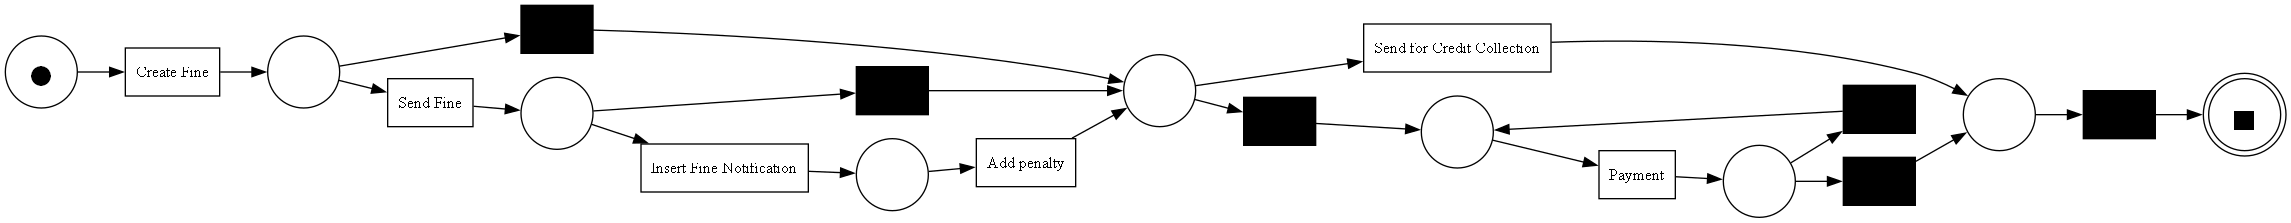

57756
55314


[(('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Send for Credit Collection'),
  26872),
 (('Create Fine', 'Payment'), 22053),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment'),
  3329),
 (('Create Fine',
   'Send Fine',
   'Insert Fine Notification',
   'Add penalty',
   'Payment',
   'Payment'),
  1683),
 (('Create Fine', 'Send Fine', 'Payment'), 1377)]

In [12]:
case_col = "case:concept:name"
act_col  = "concept:name"
time_col = "time:timestamp"

# 1) closed sublog（你前面已经算出 closed_case_ids 了就直接用）
closed_case_ids = (sent_credit | dismissed | paid_full)
closed_case_ids = closed_case_ids[closed_case_ids].index   # 这就是要的 case id 列表/Index
closed_df = df[df[case_col].isin(closed_case_ids)].copy()
closed_df = pm4py.format_dataframe(closed_df, case_id=case_col, activity_key=act_col, timestamp_key=time_col)

# 2) 计算 closed_df 的 variants（练习题就是这么干的）
variants = pm4py.get_variants_as_tuples(closed_df)  # {variant_tuple: count}

top5 = sorted(variants.items(), key=lambda x: x[1], reverse=True)[:5]
top5_variants = {v for v, cnt in top5}

# 3) 给每个 case 算它的 variant，然后只保留 top5 variant 对应的 cases
tmp = closed_df.sort_values([case_col, time_col])
case_variant = tmp.groupby(case_col)[act_col].apply(tuple)

top5_case_ids = case_variant[case_variant.isin(top5_variants)].index
filtered_closed_df = closed_df[closed_df[case_col].isin(top5_case_ids)].copy()
filtered_closed_df = pm4py.format_dataframe(filtered_closed_df, case_id=case_col, activity_key=act_col, timestamp_key=time_col)

# 4) 从过滤后的 dataframe log 直接挖 Petri net
net_e, im_e, fm_e = pm4py.discover_petri_net_inductive(filtered_closed_df)
pm4py.view_petri_net(net_e, im_e, fm_e)
print(len(closed_case_ids)  )        # 应该是 57756
print(len(top5_case_ids) )           # 这是过滤后保留下来的 case 数（<= 57756）
top5                           # 打印 top5 variants 和频数

# f) Fitness

In [13]:
# 1) log fitness（token-based replay）
fit = pm4py.fitness_token_based_replay(log, net_e, im_e, fm_e)
log_fitness = fit["log_fitness"]

# 2) 每条 trace 的 fitness -> 统计“完全拟合”的比例
diag = pm4py.conformance_diagnostics_token_based_replay(log, net_e, im_e, fm_e)
trace_fitness = np.array([d["trace_fitness"] for d in diag])

perc_perfect = (trace_fitness == 1.0).mean() * 100

perc_perfect, log_fitness

E:\Python3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
replaying log with TBR, completed traces :: 100%|██████████| 159/159 [00:00<00:00, 212.58it/s]


(np.float64(80.25782276781969), 0.9708997543726612)